# Определение уровня английского языка фильма

Просмотр фильмов на оригинальном языке - это популярный и действенный метод прокачаться при изучении иностранных языков. Важно выбрать фильм, который подходит студенту по уровню сложности, т.е. чтобы студент понимал 50-70 % диалогов.    
Уровень сложности фильма - это уровень понимания языка по шкале CEFR, от простого А1 уровня до продвинутого С2. Чтобы определить уровень, преподаватель должен посмотреть фильм и решить, какому уровню он соответствует, однако это требует больших временных затрат. Хорошо, что этот процесс можно автоматизировать с помощью моделей машинного обучения!

Цель этого проекта - разработать ML решение для автоматического определения уровня сложности англоязычных фильмов.  

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os, re, pysrt
import plotly.express as px

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tag import pos_tag

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

import pickle

Будем разделять субтитры на 4 уровня: A2, B1, B2 и C1.

In [2]:
CATS = ['A2', 'B1', 'B2', 'C1']

## Загрузка и обработка данных

Для решения задачи даны более 300 субтитров, какие-то из них лежат в папках по уровням, какие-то размечены в файле `movies_labels.xls`.       
Чтобы можно было анализировать текст субтитров, нужно их обработать: убрать лишние символы, слова, неимеющие смысла, и провести лемматизацию:

In [3]:
# функция для определения pos-тега слова
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [4]:
lemmatizer = WordNetLemmatizer()
# функция для удаления лишних символов, стоп-слов и лемматизации
def sub_preprocess(s):
    sub_prep = re.sub(r"[\d\n]", ' ', # удаляем цифры и пробелы
                re.sub("[^a-z]", ' ', # удаляем все знаки
                    re.sub(r"\<[^<>]+\>", ' ', # удаляем все что в скобках
                        re.sub(r"\([^()]+\)", ' ', s.lower()))))
    sub_prep = re.findall(r'\S+', sub_prep)
    sub_prep = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in sub_prep]
    sub_prep = ' '.join([word for word in sub_prep if word not in stopwords.words('english')])
    return sub_prep

Загрузим субтитры из папок:

In [5]:
subs1 = []
for cat in CATS:
    print(cat)
    for filename in tqdm(os.listdir(os.getcwd() + '/' + cat)):
        file = os.getcwd() + '/' + cat + '/' + filename
        sub = pysrt.open(file, encoding='iso-8859-1').text
        sub = sub_preprocess(sub)
        
        subs1.append((sub, cat))

A2


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.88s/it]


B1


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:55<00:00,  3.25s/it]


B2


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [07:33<00:00,  4.23s/it]


C1


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [01:13<00:00,  2.23s/it]


In [6]:
subs_folders = pd.DataFrame(subs1, columns=['subtitle', 'level'])

In [7]:
subs_folders['level'].value_counts()

B2    107
C1     33
B1     17
A2      5
Name: level, dtype: int64

Есть 107 субтитров уровня В2 и всего 5 уровня А2.

Загрузим размеченные субтитры, записанные в файл `movies_labels`.

In [8]:
data_x = pd.read_excel(os.getcwd() + '/' + 'movies_labels.xlsx')
data_x['Level'].unique()

array(['B1', 'B2', 'A2/A2+', 'C1', 'B1, B2', 'A2/A2+, B1', 'A2'],
      dtype=object)

Здесь разметка не такая четкая - некоторые фильмы отмечены несколькими уровнями. Заменим эти уровни:

In [9]:
data_x['Level'] = data_x['Level'].replace(['A2/A2+', 'A2/A2+, B1', 'B1, B2'], ['A2', 'A2', 'B1'])
data_x['Level'].unique()

array(['B1', 'B2', 'A2', 'C1'], dtype=object)

In [10]:
subs2 = []
for n in tqdm(range(len(data_x))):
    if (data_x.loc[n][1]+'.srt') in os.listdir(os.getcwd() + '/Subtitles/'):
        file = pysrt.open(os.getcwd() + '/Subtitles/' + data_x.loc[n][1] + '.srt', encoding='iso-8859-1').text
        sub = sub_preprocess(file)
        subs2.append((sub, data_x.loc[n][2]))

100%|████████████████████████████████████████████████████████████████████████████████| 241/241 [11:28<00:00,  2.86s/it]


In [11]:
subs_xls = pd.DataFrame(subs2, columns=['subtitle', 'level'])

In [12]:
subs_xls['level'].value_counts()

B1    45
A2    30
B2    29
C1     6
Name: level, dtype: int64

Здесь субтитров уровня А2 уже 30. Объединим данные:

In [13]:
subs_all = pd.concat([subs_folders, subs_xls]).reset_index(drop=True)
display(subs_all.head())

,subtitle,level
0,little girl policeman little girl afraid okay ...,A2
1,merle right heard bitch get problem bring man ...,A2
2,nothing nothing always something dad teach tie...,A2
3,rick morgan know know hear maybe listen right ...,A2
4,hey hey whoa whoa whoa whoa please please help...,A2


## Подготовка данных для обучения

In [14]:
subs_all['level'].value_counts()

B2    136
B1     62
C1     39
A2     35
Name: level, dtype: int64

Поскольку модель будет предсказывать классы, для лучшей работы модели эти классы нужно сбалансировать. Самый простой способ в данном случае - выбрать только 40 субтитров из многочисленных классов B1 и B2:

In [15]:
subs_fin = pd.concat([subs_all[subs_all['level']=='A2'],
                        subs_all[subs_all['level']=='B1'].sample(n=40, random_state=42),
                            subs_all[subs_all['level']=='B2'].sample(n=40, random_state=42),
                                subs_all[subs_all['level']=='C1']]).reset_index(drop=True)

In [16]:
subs_fin['level'].value_counts()

B1    40
B2    40
C1    39
A2    35
Name: level, dtype: int64

Теперь количество субтитров различается не так сильно.

Заменим классы числовыми значениями и разделим данные на выборки:

In [17]:
subs_levels = subs_fin['level'].replace(['A2', 'B1', 'B2', 'C1'], [0, 1, 2, 3])

In [18]:
features_train, features_test, labels_train, labels_test = train_test_split(
    subs_fin['subtitle'], subs_levels,
    test_size=0.25, random_state=42, stratify=subs_levels)

Далее, чтобы модель могла работать с данными, их нужно превратить в числовые. Можно сделать это с помощью `TfidfVectorizer` - он поделит текст субтитров на отдельные слова, посчитает встречаемость каждого слова в каждом субтитре и посчитает встречаемость этого слова в субтитре по отношению к встречаемости в других субтитрах. 
Это позволит найти не просто количество слов, но еще и их важность - слова, встречающиеся в каждом субтитре не будут полезны для определения уровня языка, и им будет присвоен меньший вес.

In [19]:
tf = TfidfVectorizer(max_features=1500, min_df=0, max_df=0.7)

In [20]:
tf.fit(features_train)
features_train = tf.transform(features_train).toarray()
features_test = tf.transform(features_test).toarray()

In [21]:
print(features_train[:2])
print(features_test[:2])

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.01477576 0.04694658 0.        ]]
[[0.         0.03223944 0.         ... 0.         0.0115183  0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


## Исследование данных

Каждому уровню сложности соответствует свой набор слов. На сайте [Oxford Learner's Dictionary](https://www.oxfordlearnersdictionaries.com/wordlists/oxford3000-5000) можно найти списки слов, размеченные по уровню знания языка. Для анализа будут использоваться два списка - American Oxford 3000 и 5000 by CEFR level.

Откроем текстовые файлы со списками слов:

In [22]:
def re_dict(level):
    return re.findall('[a-z]+', ' '.join(\
            re.findall(r'\n[a-z]+', level)))
oxford_ = []
for cat in CATS:
    level = re_dict(\
                open(os.getcwd() + '/' + cat + 'list.txt', 'r').read())
    oxford_.append((level, cat))

oxford_list = pd.DataFrame(oxford_, columns=['words', 'level'])
oxford_list

,words,level
0,"[ability, able, accept, accident, according, a...",A2
1,"[absolutely, academic, access, account, achiev...",B1
2,"[abandon, abroad, absolute, acceptable, accomp...",B2
3,"[abolish, abortion, absence, absent, absurd, a...",C1


Теперь можно узнать, сколько слов из каждого словаря находится в субтитрах, сколько есть уникальных слов или сколько слов в субтитрах вообще.         

Найдем для каждого уровня языка субтитров среднее общее количество слов, вошедших в словарь, среднее количество уникальных слов из словаря, а также общее количество слов в субтитрах:

In [23]:
dict_stats = []
for i in CATS:
    for j in oxford_list['level']:
        sub_stats = []
        for n in subs_fin[subs_fin['level'] == i]['subtitle']:
            l = oxford_list[oxford_list['level']==j]['words'].values[0]
            sb = [n]
            
            vb = CountVectorizer()
            vb.fit(l)

            # слова субтитров, имеющиеся в словаре
            imp = list(filter(lambda count: count > 0, vb.transform(sb).toarray()[0]))
            # уникальные слова в субтитрах
            unique = len(np.unique(sb[0].split()))
            # все слова в субтитрах
            total = len(sb[0].split())

            sub_stats.append([sum(imp), len(imp), unique, total])

        stats = pd.DataFrame(sub_stats).mean().values
        dict_stats.append([i, j, *stats])
        
stats_df = pd.DataFrame(dict_stats, columns=['sub_level', 'dict_level', 'dict_words_sum', 'dict_words_uniq',
                                             'sub_words_uniq', 'sub_words_total'])
stats_df

,sub_level,dict_level,dict_words_sum,dict_words_uniq,sub_words_uniq,sub_words_total
0,A2,A2,668.342857,209.342857,1036.057143,3846.342857
1,A2,B1,396.542857,127.571429,1036.057143,3846.342857
2,A2,B2,346.571429,129.514286,1036.057143,3846.342857
3,A2,C1,160.457143,53.800000,1036.057143,3846.342857
4,B1,A2,681.450000,222.050000,1111.500000,3805.100000
5,B1,B1,414.075000,141.400000,1111.500000,3805.100000
6,B1,B2,369.425000,145.100000,1111.500000,3805.100000
7,B1,C1,164.050000,56.350000,1111.500000,3805.100000
8,B2,A2,569.575000,198.875000,977.325000,3125.150000
9,B2,B1,359.175000,129.875000,977.325000,3125.150000


Получилать такая таблица. Значения отсортированы по уровню субтитров и в них, вроде бы, даже можно разобраться. Но всегда лучше построить график:

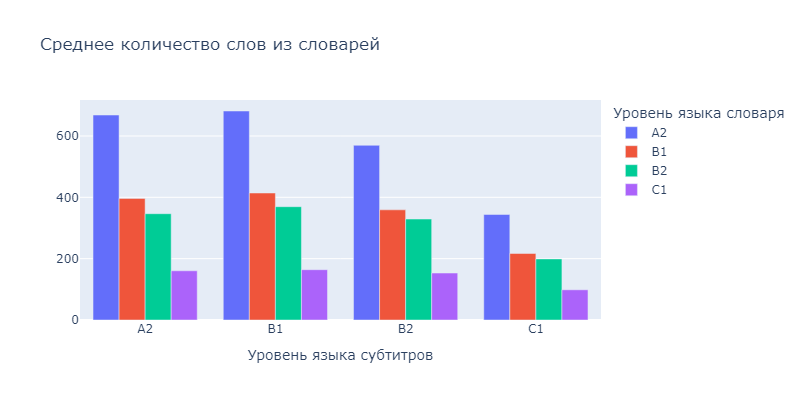

In [24]:
fig = px.bar(stats_df, x="sub_level", y="dict_words_sum", height=400, width=800,
             title='Среднее количество слов из словарей',
             color='dict_level', barmode='group', labels={'dict_words_sum': ' ',
                                                         'dict_level': 'Уровень языка словаря',
                                                         'sub_level': 'Уровень языка субтитров'})
fig.show('png')

Теперь наглядно видно, что, например, в субтитрах любого уровня обычно больше слов уровня А2. Слов уровня С1 обычно не больше 160 в любых субтитрах.

Уровень языка субтитров, возможно, получится определить по разнице между количеством простых и сложных слов - чем меньше разница, тем сложнее фильм. Уровни А2 и В1, правда, при этом почти не отличить.

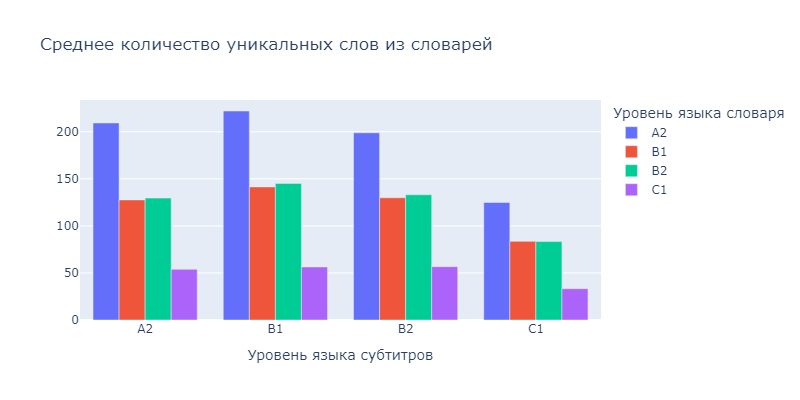

In [25]:
fig = px.bar(stats_df, x="sub_level", y="dict_words_uniq", height=400, width=800,
             title='Среднее количество уникальных слов из словарей',
             color='dict_level', barmode='group', labels={'dict_words_uniq': ' ',
                                                         'dict_level': 'Уровень языка словаря',
                                                         'sub_level': 'Уровень языка субтитров'})
fig.show('png')

С уникальными словами похожая ситуация - А2 и В1 очень похожи, уникальных слов из С1 обычно меньше всего в субтитрах, в любом фильме больше всего будет простых слов. Слова уровней В1 и В2 встречаются одинаково часто для каждого уровня субтитров.

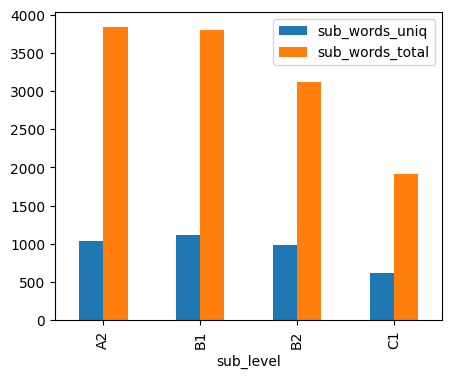

In [26]:
stats_df[~stats_df.duplicated('sub_level')][['sub_level','sub_words_uniq', 'sub_words_total']]\
        .plot(x='sub_level', kind='bar', figsize=(5,4));

На этом графике - среднее количество всех слов и уникальных слов на субтитр. Уровни А2 и В1 снова похожи, в субтитрах уровня С1, несмотря на их сложность, найдено меньше всего слов.

По количеству слов в словарях субтитры похожи. Единственная четкая зависимость - чем сложнее субтитр, тем меньше в нем было найдено слов.

## Обучение моделей

Обучим несколько моделей и посмотрим, как хорошо они смогут найти зависимости в этих данных.

Первая модель - **случайный лес.** Она довольно простая и дает неплохие результаты. Поскольку мы решаем задачу с 4 классами, для улучшения качества можно попробовать обернуть лес в `OneVsRestClassifier`: этот классификатор строит базовую модель для каждого класса и сравнивает его с остальными классами. В нашем случае внутри "Один-против-Всех" модели будет 4 модели леса. Кросс-валидация и подбор параметров может занять много времени, но, может быть, это даст хорошую `accuracy`.

Построим базовую модель:

In [27]:
cross_validate(OneVsRestClassifier(RandomForestClassifier(random_state=42)),
               X=features_train, y=labels_train, scoring='accuracy', cv=3)['test_score'].mean()

0.6695906432748537

Аccuracy равна 0.66, неплохой результат. Подберем гиперпараметры:

In [28]:
params_forest = {'estimator__n_estimators': list(range(5, 105, 25)),
                 'estimator__max_depth': [3, 5, 7, 9]}

forestgrid = GridSearchCV(estimator=OneVsRestClassifier(RandomForestClassifier(random_state=42)),
                          param_grid=params_forest, scoring='accuracy', cv=3).fit(features_train, labels_train)

In [29]:
print(forestgrid.best_score_)
print(forestgrid.best_params_)

0.6869095816464238
{'estimator__max_depth': 7, 'estimator__n_estimators': 80}


Подбор занял больше времени, что неудивительно. Результат немного улучшился - accuracy теперь 0.68.

Построим другую модель.

Оценщик **SGDClassifier** собрал в себе несколько моделей линейной классификации, которые обучаются стохастическим градиентным спуском. Чтобы обучить другую модель, достаточно поменять функцию потерь. Но некоторые из моделей не предсказывают вероятности классов, которые в нашем случае будут полезны для интерпретации результата предсказания. Получить вероятности можно, обернув модели в `CalibratedClassifierCV` - калибровщик вероятностей. Он делит обучающие данные на фолды, обучает базовую модель на тренировочном, калибрует на тестовом, и выдает финальный оценщик. Этот оценщик - ансамбль из базовых моделей и их калибровщиков. Результат его работы - средняя вероятность классов, предсказанных ансамблем.

Довольно сложно. Обучим базовую модель, проверим качество кросс-валидацией:

In [30]:
cross_validate(CalibratedClassifierCV(SGDClassifier(random_state=42), cv=3),
               X=features_train, y=labels_train, scoring='accuracy', cv=3)['test_score'].mean()

0.6601439496176338

Несмотря на сложность модель обучается быстро. Результат похож на лес - accuracy равна 0.66. 

Подберем гиперпараметры. Один из них - функция потерь `loss` - будет менять модель целиком, от логистической регрессии до алгоритма SVM и перцептрона:

In [31]:
params_sgd = {'estimator__loss':['hinge', 'log_loss', 'perceptron'],
              'estimator__alpha': [0.01, 0.001, 0.0001, 0.00001],
              'estimator__max_iter': [500, 1000, 2000, 3000, 4000]}

sgdgrid = GridSearchCV(estimator=CalibratedClassifierCV(SGDClassifier(random_state=42), cv=3),
                       param_grid=params_sgd, scoring='accuracy', cv=3).fit(features_train, labels_train)

In [32]:
print(sgdgrid.best_score_)
print(sgdgrid.best_params_)

0.7125506072874493
{'estimator__alpha': 0.001, 'estimator__loss': 'perceptron', 'estimator__max_iter': 500}


Лучшая точность получилась у модели с функцией потерь `perceptron` - 0.71.

## Тест модели

Протестируем модель с лучшей метрикой.

In [33]:
sgdgrid.best_estimator_.fit(features_train, labels_train)

pred = sgdgrid.best_estimator_.predict(features_test)
accuracy_score(labels_test, pred)

0.717948717948718

Аccuracy не ухудшилась, даже стала лучше на 0.005 - 0.717.

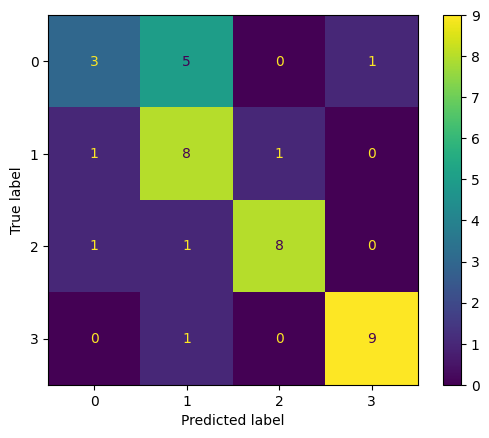

In [36]:
cm = confusion_matrix(labels_test, pred)
cmp = ConfusionMatrixDisplay(cm, display_labels = sgdgrid.best_estimator_.classes_)
cmp.plot();

Матрица ошибок показывает, что модель очень любит предсказывать класс 1, он же В1, и не любит предсказывать класс 0, он же А2.       
С классами 2 и 3 таких проблем нет.

Действительно, из анализа субтитров можно вспомнить, что в количестве слов определенного уровня для субтитров А2 и В1 большой разницы не было. Сложность фильмов с такими субтитрами можно легко спутать, если не учитывать другие особенности языка - может, фразы и речевые конструкции или даже скорость речи. А может для обучения просто нужна была выборка больше, чем 120 субтитров. Скорее всего - все вместе.

## Итоги

Исследование закончено. Лучшая найденная модель - откалиброванный `SGDClassifier` с алгоритмом `perceptron` - показывает `accuracy` равную 0.717 на тестовой выборке.

Из исследования данных видно, что:
- слов из С1 в субтитрах всегда меньше;
- в любом фильме простых слов будет больше;
- количество слов разных уровней в фильмах А2 и В1 почти одинаково;
- слова уровней В1 и В2 встречаются одинаково часто для каждого уровня субтитров;
- чем сложнее субтитр, тем меньше в нем определяется слов.

Для выполнения работы были изучены основные принципы обработки языка - стемминг, лемматизация, модель мешка слов и TF-IDF.      
Большую часть времени выполнения тетрадки заняла загрузка и обработка файлов - лемматизация с правильными тегами частей речи слов оказалась затратным по вычислениям процессом. Для улучшения качества предсказания можно было бы добавить данных, но тогда, наверное, пришлось бы выбрать другой способ приведения слов к основе. Можно было бы также добавить признаков - например, скорость речи, количество слов, отношение уникальных слов ко всем.

Цель проекта - разработать ML решение для предсказания уровня языка фильма - почти достигнута. Осталось только развернуть приложение, которым можно было бы пользоваться. Для работы приложения нужны будут модель, TF-IDF трансформер для обработки субтитров и словарь с уровнями. Также можно сохранить таблицу со статистикой по субтитрам - возможно пользователям будет интересно сравнить информацию о загруженном субтитре с другими такого же уровня.

Сохраним нужные объекты в файлы:

In [37]:
with open('model.pickle', 'wb') as f:
    pickle.dump(sgdgrid.best_estimator_, f, pickle.HIGHEST_PROTOCOL)
    
with open('vectorizer.pickle', 'wb') as f:
    pickle.dump(tf, f, pickle.HIGHEST_PROTOCOL)
    
with open('wordlist.pickle', 'wb') as f:
    pickle.dump(oxford_list, f, pickle.HIGHEST_PROTOCOL)
    
with open('stats.pickle', 'wb') as f:
    pickle.dump(stats_df, f, pickle.HIGHEST_PROTOCOL)